In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import random
import os
from urllib.parse import urljoin
import json

First the links are scraped by performing the correct request.

In [3]:
url = "https://areiospagos.gr/nomologia/apofaseis_result.asp?S=1"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
}

params = {
    "X_TELESTIS_ETOS": "1",
    "x_ETOS": "2024",
}



response = requests.get(url, data=params,headers=headers)
response.encoding = 'windows-1253'



In [4]:
from urllib.parse import urljoin, unquote
decision_ids = []
years = []
sections = []
unique_ids = []
urls = []

base_nomologia_url = "https://www.areiospagos.gr/nomologia/"

results = []
soup = BeautifulSoup(response.text, 'html.parser')

for a in soup.find_all("a", href=True):
    href = a['href']
    if "apofaseis_DISPLAY.asp" in href:
        full_url = urljoin(base_nomologia_url, href)
        decision_id = a.get_text(strip=True)
        year = decision_id.split("/")[-1] if "/" in decision_id else None

        cd_match = re.search(r"cd=([^&]+)", href)
        info_match = re.search(r"info=([^&]+)", href)

        uid = cd_match.group(1) if cd_match else None
        section_info = unquote(info_match.group(1)) if info_match else None

        results.append({
            "decision_id": decision_id,
            "year": year,
            "uid": uid,
            "section": section_info,
            "url": full_url
        })

df = pd.DataFrame(results)
df.to_csv("apofaseis_links.csv", index=False, encoding="utf-8-sig")
print(df.head())       



  decision_id  year                             uid          section  \
0     11/2024  2024  RWKDTA2X1554EH8YXW0M7NFLRRV23P  ΠΟΛΙΤΙΚΕΣ -  Β1   
1     12/2024  2024  N1RABGMSWJWJ7DHP4GZ8JI6Q4TFTMD  ΠΟΛΙΤΙΚΕΣ -  Β1   
2     13/2024  2024  RSMY30KIH82MLOOC1VPLFAXXXSO0UO  ΠΟΛΙΤΙΚΕΣ -  Β1   
3     14/2024  2024  ZU5LE0TC6T0315OGAQ6IMDLESK4ST3  ΠΟΛΙΤΙΚΕΣ -  Β1   
4     31/2024  2024  RMR33L8SVVS7NNHF953HQAIZ6BH2BY  ΠΟΛΙΤΙΚΕΣ -  Β1   

                                                 url  
0  https://www.areiospagos.gr/nomologia/apofaseis...  
1  https://www.areiospagos.gr/nomologia/apofaseis...  
2  https://www.areiospagos.gr/nomologia/apofaseis...  
3  https://www.areiospagos.gr/nomologia/apofaseis...  
4  https://www.areiospagos.gr/nomologia/apofaseis...  


Each page is scraped to get the html.

In [21]:
df_links = pd.read_csv("apofaseis_links.csv")

crawled = []

for i, row in df_links.iterrows():
    print(f"Crawling {i+1}/{len(df_links)}: {row['decision_id']}")
    try:
        r = requests.get(row["url"], timeout=10)
        r.encoding = 'windows-1253'
        crawled.append({
            "decision_id": row["decision_id"],
            "year": row["year"],
            "uid": row["uid"],
            "section": row["section"],
            "url": row["url"],
            "html": r.text
        })
        time.sleep(1)
    except Exception as e:
        print(f"Error fetching {row['url']}: {e}")
        continue

df_raw = pd.DataFrame(crawled)
df_raw.to_csv("apofaseis_raw.csv", index=False, encoding="utf-8-sig")
print("Saved raw crawled data to apofaseis_raw.csv")


Crawling 1/2475: 11/2024
Crawling 2/2475: 12/2024
Crawling 3/2475: 13/2024
Crawling 4/2475: 14/2024
Crawling 5/2475: 31/2024
Crawling 6/2475: 32/2024
Crawling 7/2475: 33/2024
Crawling 8/2475: 37/2024
Crawling 9/2475: 38/2024
Crawling 10/2475: 39/2024
Crawling 11/2475: 54/2024
Crawling 12/2475: 55/2024
Crawling 13/2475: 56/2024
Crawling 14/2475: 57/2024
Crawling 15/2475: 113/2024
Crawling 16/2475: 114/2024
Crawling 17/2475: 115/2024
Crawling 18/2475: 116/2024
Crawling 19/2475: 117/2024
Crawling 20/2475: 118/2024
Crawling 21/2475: 119/2024
Crawling 22/2475: 120/2024
Crawling 23/2475: 182/2024
Crawling 24/2475: 183/2024
Crawling 25/2475: 184/2024
Crawling 26/2475: 185/2024
Crawling 27/2475: 186/2024
Crawling 28/2475: 187/2024
Crawling 29/2475: 188/2024
Crawling 30/2475: 204/2024
Crawling 31/2475: 205/2024
Crawling 32/2475: 206/2024
Crawling 33/2475: 207/2024
Crawling 34/2475: 283/2024
Crawling 35/2475: 284/2024
Crawling 36/2475: 285/2024
Crawling 37/2475: 286/2024
Crawling 38/2475: 287/20

The required data are extracted.

In [ ]:
import regex
import concurrent.futures



STOP_PATTERN = re.compile(r"(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|Η ΓΡΑΜΜΑΤΕΑΣ|ΚΡΙΘΗΚΕ|ΔΗΜΟΣΙΕΥΘΗΚΕ|ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ)", re.IGNORECASE)

ARTICLE_GROUP_PATTERN = re.compile(
    r"άρθρα?\s+((?:\d+[Α-Ω]?(?:\s*παρ\.?\s*\d+)?(?:,\s*)?)+(?:\s*και\s*\d+[Α-Ω]?(?:\s*παρ\.?\s*\d+)?)*?)\s*(?:του|της)?\s*(ΚΠολΔ|ΠΚ|ΚΠΔ|ΑΚ)\b",
    re.IGNORECASE
)

SINGLE_ARTICLE_PATTERN = re.compile(
    r"άρθρ?ο?\s+(\d+[Α-Ω]?(?:\s*παρ\.?\s*\d+)?(?:\s*αριθμ\.?\s*\d+)?)(?:\s+του|της)?\s+(ΚΠολΔ|ΠΚ|ΚΠΔ|ΑΚ)\b",
    re.IGNORECASE
)

def extract_legal_articles(text):
    if not isinstance(text, str):
        return []

    results = set()

    for group, code in ARTICLE_GROUP_PATTERN.findall(text):
        code = code.upper()
        parts = re.split(r",|\s+και\s+", group)
        for part in parts:
            part = part.strip()
            if part:
                results.add(f"{code} {part}")

    for article, code in SINGLE_ARTICLE_PATTERN.findall(text):
        results.add(f"{code.upper()} {article.strip()}")

    return sorted(results)

def extract_section_from_text(text, marker):
    lines = text.splitlines()
    collecting = False
    collected = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if not collecting and re.search(marker, line, re.IGNORECASE):
            collecting = True
            collected.append(line)
            continue
        if collecting:
            if STOP_PATTERN.search(line):
                break
            collected.append(line)
    return "\n".join(collected).strip() if collected else None

import regex

def extract_judges(text):
    if not isinstance(text, str) or len(text.strip()) < 5:
        return []

    text = regex.sub(r"(?<=[α-ω])(?=[Α-Ω])", " ", text)

    match = regex.search(
        r"(Συγκροτήθηκε|ΣΥΓΚΡΟΤΗΘΗΚΕ)\s+από\s+(?:τους|τις|τον)\s*(?::|\s+Δικαστές:?)?\s*(?P<judges>.+?)\s+(?:Αρεοπαγίτες(?:\.|,)?|\.\s*|\Z)",
        text,
        flags=regex.DOTALL | regex.IGNORECASE
    )

    if not match:
        match = regex.search(
            r"αποτελούμενη\s+από\s+(?P<judges>.+?)\s*(?:\.|$)",
            text,
            flags=regex.DOTALL | regex.IGNORECASE
        )
    if not match:
        return []

    block = match.group("judges")

    block = regex.sub(r"σύμφωνα με .*?,", "", block, flags=regex.IGNORECASE)

    block = regex.sub(r"\((?:[^()]+|(?R))*\)", "", block)

    block = regex.sub(r"-?\s*Εισηγητ[ήη](?:ς|ρια)?", "", block)
    
    block = regex.sub(
        r"(?i)\b("
        r"Προεδρεύοντα\s+Αρεοπαγίτη(?:\s+\([^)]+\))?|"
        r"Πρόεδρο\s+του\s+καθ['']?\s+ύλη\s+αρμοδίου\s+Πολιτικού\s+Τμήματος\s*\([Α-Ω']?\)|"
        r"Πολιτικού\s+Τμήματος\s*\([Α-Ω']?\)|"
        r"Πολιτικού\s+Τμήματος\s+(?=\p{Lu})|"
        r"Αντιπρόεδρο(?:ς)?(?:\s+του\s+Αρείου\s+Πάγου)?|"
        r"Πρόεδρο(?:ς)?(?:\s+του\s+Αρείου\s+Πάγου)?|"
        r"Εφέτ[ηςες]|Αρεοπαγίτ[ηςες]|Εισηγητ[ήρ](?:ια)?|"
        r"Ψηφίσαντ[εςας]?|"
        r"νόμιμα\s+αναπληρούμενο[ςν]?|που\s+έχει\s+κώλυμα|"
        r"Αρείου\s+Πάγου|Αρεοπαγίτου|Δικαστή[ςσ]|"
        r"του\s+Αρείου\s+Πάγου|της\s+Δικαιοσύνης"
        r")\b",
        "", block
    )
    
    block = regex.sub(r"\s+", " ", block).strip()

    parts = regex.split(r",\s*|\s+και\s+", block)
    judges = []

    for part in parts:
        part = part.strip(" -.,:")

        names = regex.findall(
            r'\p{Lu}[\p{Ll}\p{Pd}]+(?:\s*-\s*)?\s+\p{Lu}[\p{Ll}\p{Pd}]+(?:\s*-\s*\p{Lu}[\p{Ll}\p{Pd}]+)?',
            part
        )
        for name in names:
            clean = regex.sub(r"\s+", " ", name.replace(" - ", " ").strip(" -.,:"))
            if len(clean) > 3:
                judges.append(clean)

    return list(dict.fromkeys(judges))


def parse_decision_page(html):
    soup = BeautifulSoup(html, 'html.parser')
    raw = soup.get_text("\n", strip=True)
    text = re.sub(r"\s+", " ", raw).strip()
    articles = extract_legal_articles(text)
    intro = extract_section_from_text(raw, r"(ΤΟ\s+ΔΙΚΑΣΤΗ\s*Ρ?ΙΟ\s+ΤΟΥ\s+)?ΑΡΕΙΟΥ\s+ΠΑΓΟΥ")
    reasoning = extract_section_from_text(raw, r"(ΣΚΕΦ[ΘΤ]ΗΚΕ\s+ΣΥΜΦΩΝΑ\s+ΜΕ\s+ΤΟΝ?\s+ΝΟΜΟ|Αφού\s+έλαβε\s+υπόψη:)")
    decision = extract_section_from_text(raw, r"ΓΙΑ\s*ΤΟΥΣ\s*ΛΟΓΟΥΣ(?:\s*ΑΥΤΟΥΣ(?:\s*ΔΙΑΤΑΣΣΕΙ:)?)?")
    judges = extract_judges(text)
    return {
        "judges": judges,
        "intro_text": intro,
        "legal_reasoning": reasoning,
        "final_decision": decision,
        "articles": articles,
        "raw_text": text
    }

df_raw = pd.read_csv("apofaseis_raw.csv")
enriched = []
TIMEOUT_SECONDS = 10

for i, row in df_raw.iterrows():
    if i==1880 or i==1873 or i==1875 or i==1882:
        continue
    print(f"Parsing {i+1}/{len(df_raw)}: {row['decision_id']}")
    try:
        parsed = parse_decision_page(row['html'])
        section_parts = row["section"].split("-")
        section = section_parts[0].strip() if len(section_parts) > 0 else None
        section_number = section_parts[1].strip() if len(section_parts) > 1 else None
        enriched.append({
            "decision_id": row["decision_id"],
            "year": row["year"],
            "uid": row["uid"],
            "section": section,
            "section_number": section_number,
            "url": row["url"],
            **parsed
        })
    except concurrent.futures.TimeoutError:
        print(f"Timeout parsing decision {row['decision_id']}")
        continue
    except Exception as e:
        print(f"Parse error: {e}")
        continue

df_final = pd.DataFrame(enriched)
df_final.to_csv("apofaseis_full.csv", index=False, encoding="utf-8-sig")
print("Saved enriched data to apofaseis_full.csv")


Parsing 1/2475: 11/2024
Parsing 2/2475: 12/2024
Parsing 3/2475: 13/2024
Parsing 4/2475: 14/2024
Parsing 5/2475: 31/2024
Parsing 6/2475: 32/2024
Parsing 7/2475: 33/2024
Parsing 8/2475: 37/2024
Parsing 9/2475: 38/2024
Parsing 10/2475: 39/2024
Parsing 11/2475: 54/2024
Parsing 12/2475: 55/2024
Parsing 13/2475: 56/2024
Parsing 14/2475: 57/2024
Parsing 15/2475: 113/2024
Parsing 16/2475: 114/2024
Parsing 17/2475: 115/2024
Parsing 18/2475: 116/2024
Parsing 19/2475: 117/2024
Parsing 20/2475: 118/2024
Parsing 21/2475: 119/2024
Parsing 22/2475: 120/2024
Parsing 23/2475: 182/2024
Parsing 24/2475: 183/2024
Parsing 25/2475: 184/2024
Parsing 26/2475: 185/2024
Parsing 27/2475: 186/2024
Parsing 28/2475: 187/2024
Parsing 29/2475: 188/2024
Parsing 30/2475: 204/2024
Parsing 31/2475: 205/2024
Parsing 32/2475: 206/2024
Parsing 33/2475: 207/2024
Parsing 34/2475: 283/2024
Parsing 35/2475: 284/2024
Parsing 36/2475: 285/2024
Parsing 37/2475: 286/2024
Parsing 38/2475: 287/2024
Parsing 39/2475: 288/2024
Parsing 4

Some additional cleaning.

In [72]:
import re

patterns = [
    r"Αυτόματη μετάφραση.*?προσοχή",    
    r"Google automatic translation.*?caution",  
    r"Σύνδεσμος απόφασης << Επιστροφή",  
    r"^\(.*?\)\s*",                      
]
df_final = pd.read_csv("apofaseis_full.csv", encoding="utf-8-sig", on_bad_lines='skip')

for pattern in patterns:
    df_final['raw_text'] = df_final['raw_text'].astype(str).str.replace(pattern, "", regex=True)

df_final.to_csv("apofaseis_final.csv", index=False, encoding="utf-8-sig")




The decision dates are then extracted

In [73]:
import re
import pandas as pd
from datetime import datetime

greek_months = {
    'Ιανουαρίου': 1, 'Φεβρουαρίου': 2, 'Μαρτίου': 3, 'Απριλίου': 4,
    'Μαΐου': 5, 'Ιουνίου': 6, 'Ιουλίου': 7, 'Αυγούστου': 8,
    'Σεπτεμβρίου': 9, 'Οκτωβρίου': 10, 'Νοεμβρίου': 11, 'Δεκεμβρίου': 12
}

decision_date_pattern = re.compile(
    r"(ΚΡΙΘΗΚ[ΕΕ]|ΑΠΟΦΑΣΙΣΤΗΚΕ)(.*?)(?:την|στις)\s+"
    r"(\d{1,2})\s+"
    r"(Ιανουαρίου|Φεβρουαρίου|Μαρτίου|Απριλίου|Μαΐου|Ιουνίου|Ιουλίου|"
    r"Αυγούστου|Σεπτεμβρίου|Οκτωβρίου|Νοεμβρίου|Δεκεμβρίου)"
    r"\s+(\d{4})",
    re.IGNORECASE
)

def extract_greek_written_date(text):
    text = str(text)
    match = decision_date_pattern.search(text)
    if match:
        _, _, day, month_gr, year = match.groups()
        month = greek_months.get(month_gr.capitalize())
        if month:
            try:
                return datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d")
            except ValueError:
                return None
    return None

scraped_df = pd.read_csv("apofaseis_final.csv", encoding="utf-8-sig", on_bad_lines='skip')

scraped_df["dates"] = scraped_df["raw_text"].apply(extract_greek_written_date)
scraped_df.to_csv("apofaseis_final.csv", index=False, encoding="utf-8-sig")


In [86]:
import pandas as pd

df = pd.read_csv("apofaseis_cleaned.csv", encoding="utf-8-sig")

missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Non-Null Count': df.notnull().sum().values,
    'Missing Count': df.isnull().sum().values,
    'Missing (%)': (df.isnull().sum() / len(df) * 100).values.round(2),
    'Data Type': df.dtypes.values
})

missing_summary = missing_summary.sort_values(by='Missing (%)', ascending=False)

print(missing_summary)

             Column  Non-Null Count  Missing Count  Missing (%) Data Type
12            dates            1756            715        28.94    object
9    final_decision            2460             11         0.45    object
7        intro_text            2462              9         0.36    object
8   legal_reasoning            2465              6         0.24    object
0       decision_id            2471              0         0.00    object
4    section_number            2471              0         0.00    object
3           section            2471              0         0.00    object
2               uid            2471              0         0.00    object
1              year            2471              0         0.00     int64
5               url            2471              0         0.00    object
6            judges            2471              0         0.00    object
10         articles            2471              0         0.00    object
11         raw_text            2471   

In [4]:
from datasets import load_dataset

dataset = load_dataset("DominusTea/GreekLegalSum", split="train")

df = dataset.to_pandas()
df.to_csv("greek_legal_sum.csv", index=False, encoding="utf-8-sig")


d:\Users\anast\AppData\Local\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


scraped_df = pd.read_csv("apofaseis_final.csv", encoding="utf-8-sig", on_bad_lines='skip')
huggingface_df = pd.read_csv("greek_legal_sum.csv",encoding="utf-8-sig")


In [75]:
print("Scraped Dataset Columns:\n", scraped_df.dtypes)
print("\nHuggingFace Dataset Columns:\n", huggingface_df.dtypes)

Scraped Dataset Columns:
 decision_id        object
year                int64
uid                object
section            object
section_number     object
url                object
judges             object
intro_text         object
legal_reasoning    object
final_decision     object
articles           object
raw_text           object
dates              object
dtype: object

HuggingFace Dataset Columns:
 text              object
summary           object
case_category     object
case_tags         object
subset           float64
dtype: object


Some metrics for the datasets and historgrams to display the text length destribution.

Dataset Dimensions:
Scraped Dataset: 2471 rows, 19 columns
HuggingFace Dataset: 8395 rows, 9 columns

Shared Columns:
{'decision_id', 'ratio', 'summary_len', 'text_len'}

Scraped-only Columns:
{'dates', 'articles_parsed_with_paragraphs', 'year', 'judges', 'final_decision', 'raw_text', 'articles', 'uid', 'intro_text', 'articles_parsed', 'judges_parsed', 'section_number', 'section', 'url', 'legal_reasoning'}

HuggingFace-only Columns:
{'case_tags', 'subset', 'text', 'case_category', 'summary'}

Year Coverage:
HuggingFace: 2002.0 to 2017.0


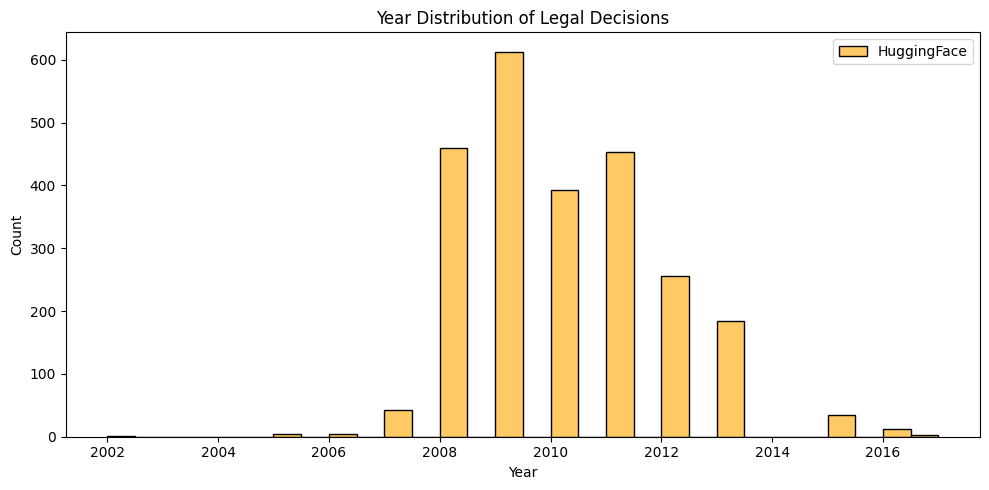


Average Text Length (words):
Scraped: 5731.81
HuggingFace: 2781.46

Average Summary Length (words):
Scraped: 109.18
HuggingFace: 74.47


In [96]:
print("Dataset Dimensions:")
print(f"Scraped Dataset: {scraped_df.shape[0]} rows, {scraped_df.shape[1]} columns")
print(f"HuggingFace Dataset: {huggingface_df.shape[0]} rows, {huggingface_df.shape[1]} columns")

scraped_cols = set(scraped_df.columns)
hf_cols = set(huggingface_df.columns)

print("\nShared Columns:")
print(scraped_cols.intersection(hf_cols))

print("\nScraped-only Columns:")
print(scraped_cols - hf_cols)

print("\nHuggingFace-only Columns:")
print(hf_cols - scraped_cols)

def extract_year(text):
    match = re.search(r'ΑΡΙΘΜΟΣ\s+\d+/(\d{4})', str(text).upper())
    return int(match.group(1)) if match else None

huggingface_df['year'] = huggingface_df['text'].apply(extract_year)

if 'year' in huggingface_df.columns:
    print("\nYear Coverage:")
    print(f"HuggingFace: {huggingface_df['year'].min()} to {huggingface_df['year'].max()}")

    plt.figure(figsize=(10, 5))
    sns.histplot(huggingface_df['year'], label="HuggingFace", kde=False, bins=30, color='orange', alpha=0.6)
    plt.legend()
    plt.title("Year Distribution of Legal Decisions")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

scraped_df['text_len'] = scraped_df['raw_text'].astype(str).apply(lambda x: len(x.split()))
scraped_df['summary_len'] = scraped_df['final_decision'].astype(str).apply(lambda x: len(x.split()))
huggingface_df['text_len'] = huggingface_df['text'].astype(str).apply(lambda x: len(x.split()))
huggingface_df['summary_len'] = huggingface_df['summary'].astype(str).apply(lambda x: len(x.split()))

print("\nAverage Text Length (words):")
print(f"Scraped: {scraped_df['text_len'].mean():.2f}")
print(f"HuggingFace: {huggingface_df['text_len'].mean():.2f}")

print("\nAverage Summary Length (words):")
print(f"Scraped: {scraped_df['summary_len'].mean():.2f}")
print(f"HuggingFace: {huggingface_df['summary_len'].mean():.2f}")

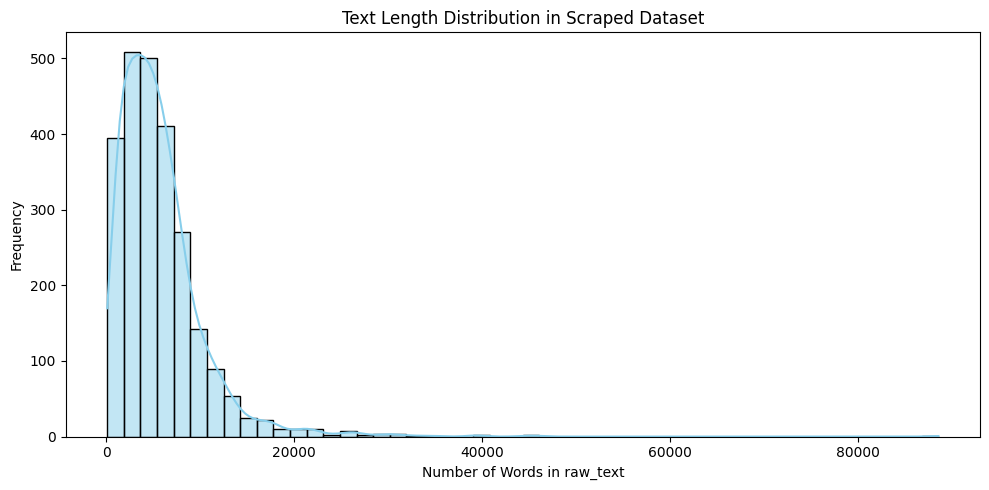

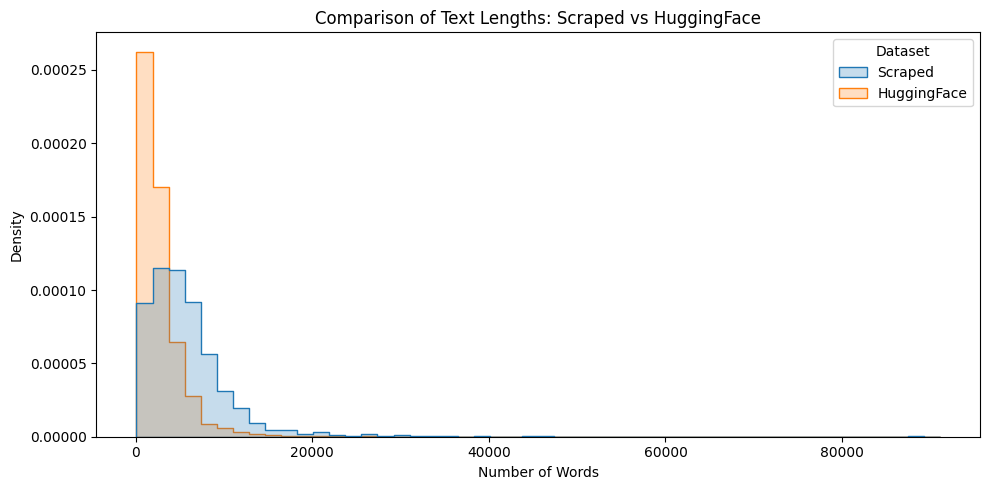

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



scraped_df['text_len'] = scraped_df['raw_text'].astype(str).apply(lambda x: len(x.split()))
huggingface_df['text_len'] = huggingface_df['text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(scraped_df['text_len'], bins=50, kde=True, color='skyblue')
plt.title("Text Length Distribution in Scraped Dataset")
plt.xlabel("Number of Words in raw_text")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


lengths_df = pd.concat([
    pd.DataFrame({'Dataset': 'Scraped', 'Text Length': scraped_df['text_len']}),
    pd.DataFrame({'Dataset': 'HuggingFace', 'Text Length': huggingface_df['text_len']})
])

plt.figure(figsize=(10, 5))
sns.histplot(data=lengths_df, x="Text Length", hue="Dataset", bins=50, element="step", stat="density", common_norm=False)
plt.title("Comparison of Text Lengths: Scraped vs HuggingFace")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


The summary/ration is calculated and displayed using a violin chart, as it combines statistical indicators (like median and quartiles) with the distribution density,

C:\Users\Admin\AppData\Local\Temp\ipykernel_25256\774080407.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=ratio_df, x='Dataset', y='Ratio', inner='quartile', palette="Set2")


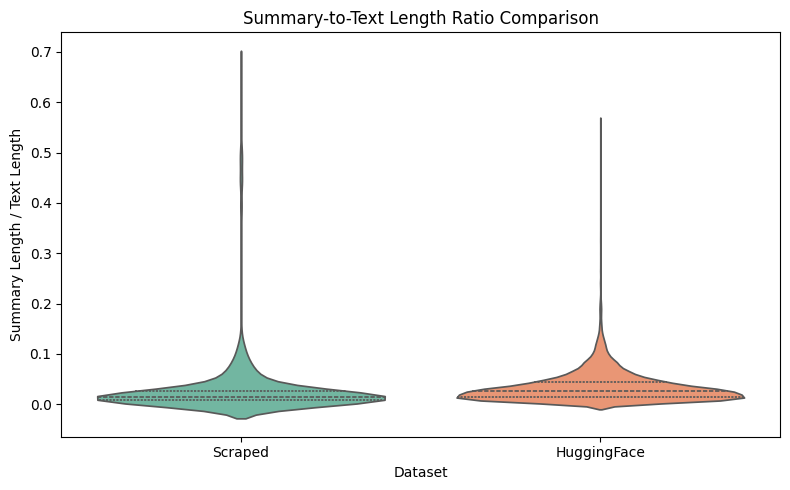

In [93]:


scraped_df['text_len'] = scraped_df['raw_text'].astype(str).apply(lambda x: len(x.split()))
scraped_df['summary_len'] = scraped_df['final_decision'].astype(str).apply(lambda x: len(x.split()))
huggingface_df['text_len'] = huggingface_df['text'].astype(str).apply(lambda x: len(x.split()))
huggingface_df['summary_len'] = huggingface_df['summary'].astype(str).apply(lambda x: len(x.split()))

scraped_df = scraped_df[scraped_df['text_len'] > 0]
huggingface_df = huggingface_df[huggingface_df['text_len'] > 0]

scraped_df['ratio'] = scraped_df['summary_len'] / scraped_df['text_len']
huggingface_df['ratio'] = huggingface_df['summary_len'] / huggingface_df['text_len']

ratio_df = pd.concat([
    pd.DataFrame({'Dataset': 'Scraped', 'Ratio': scraped_df['ratio']}),
    pd.DataFrame({'Dataset': 'HuggingFace', 'Ratio': huggingface_df['ratio']})
])

plt.figure(figsize=(8, 5))
sns.violinplot(data=ratio_df, x='Dataset', y='Ratio', inner='quartile', palette="Set2")
plt.title("Summary-to-Text Length Ratio Comparison")
plt.ylabel("Summary Length / Text Length")
plt.tight_layout()
plt.show()


A Bar Chart is used to display number of decisions per section.

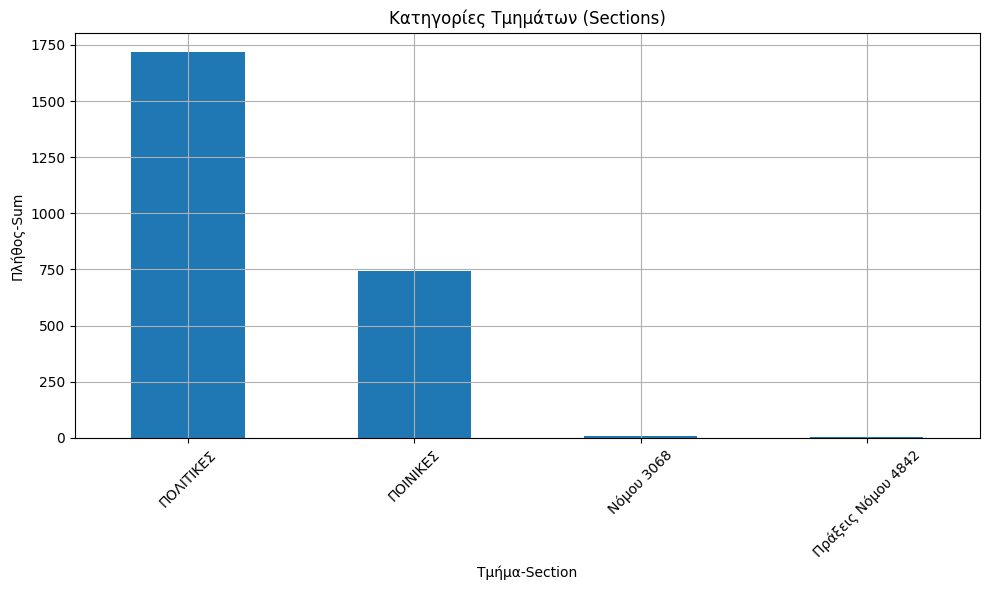

In [76]:
plt.figure(figsize=(10, 6))
scraped_df['section'].value_counts().plot(kind='bar')
plt.title('Κατηγορίες Τμημάτων (Sections)')
plt.xlabel('Τμήμα-Section')
plt.ylabel('Πλήθος-Sum')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


The same is done with a horizontal bar chart for section numbers.

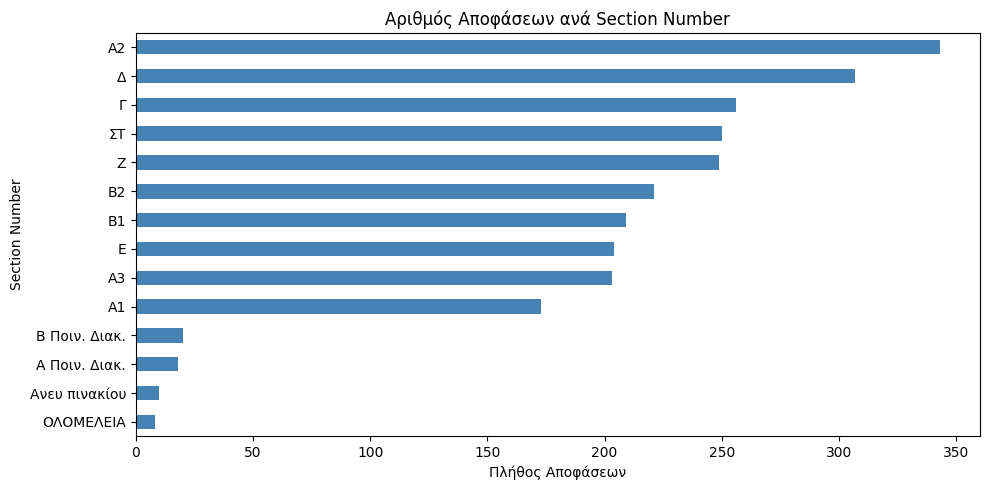

In [97]:
section_counts = df['section_number'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10, 5))
section_counts.plot(kind='barh', color='steelblue')
plt.title("Αριθμός Αποφάσεων ανά Section Number")
plt.xlabel("Πλήθος Αποφάσεων")
plt.ylabel("Section Number")
plt.tight_layout()
plt.show()

A horizontal bar chart for most common articles

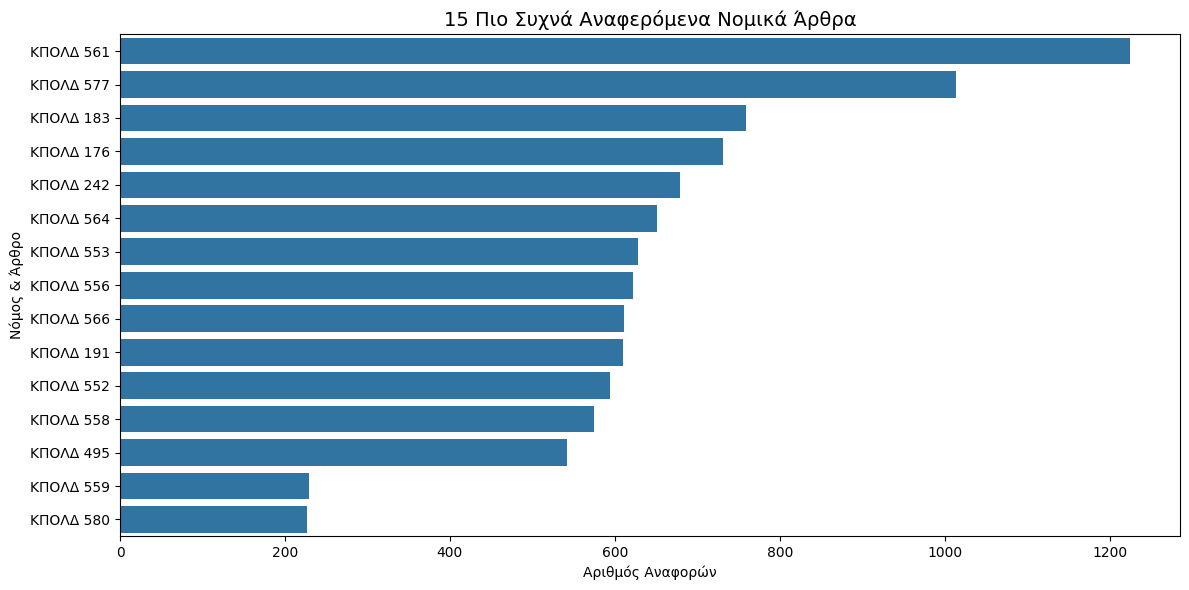

In [78]:
from collections import Counter



def parse_article_list(val):
    if isinstance(val, str) and val.strip().startswith("["):
        try:
            val = val.replace("\n", " ").replace("\r", " ").replace("\t", " ")
            return ast.literal_eval(val)
        except:
            return []
    elif isinstance(val, list):
        return val
    return []

def normalize_article(article):
    if not isinstance(article, str):
        return None
    article = article.strip()
    match = re.match(r"\b([Α-ΩΪΫA-Z]{2,})\s*(\d{1,4})\b", article)
    if match:
        return f"{match.group(1)} {match.group(2)}"
    return None

scraped_df['articles_parsed'] = scraped_df['articles'].apply(parse_article_list)

normalized_articles = [
    normalize_article(article)
    for sublist in scraped_df['articles_parsed']
    for article in sublist
    if isinstance(article, str)
]

normalized_articles = [a for a in normalized_articles if a]
article_counts = Counter(normalized_articles)
top_articles = dict(article_counts.most_common(15))

if top_articles:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(top_articles.values()), y=list(top_articles.keys()))
    plt.title("15 Πιο Συχνά Αναφερόμενα Νομικά Άρθρα", fontsize=14)
    plt.xlabel("Αριθμός Αναφορών")
    plt.ylabel("Νόμος & Άρθρο")
    plt.tight_layout()
    plt.show()
else:
    print("Δεν βρέθηκαν έγκυρα άρθρα για απεικόνιση.")




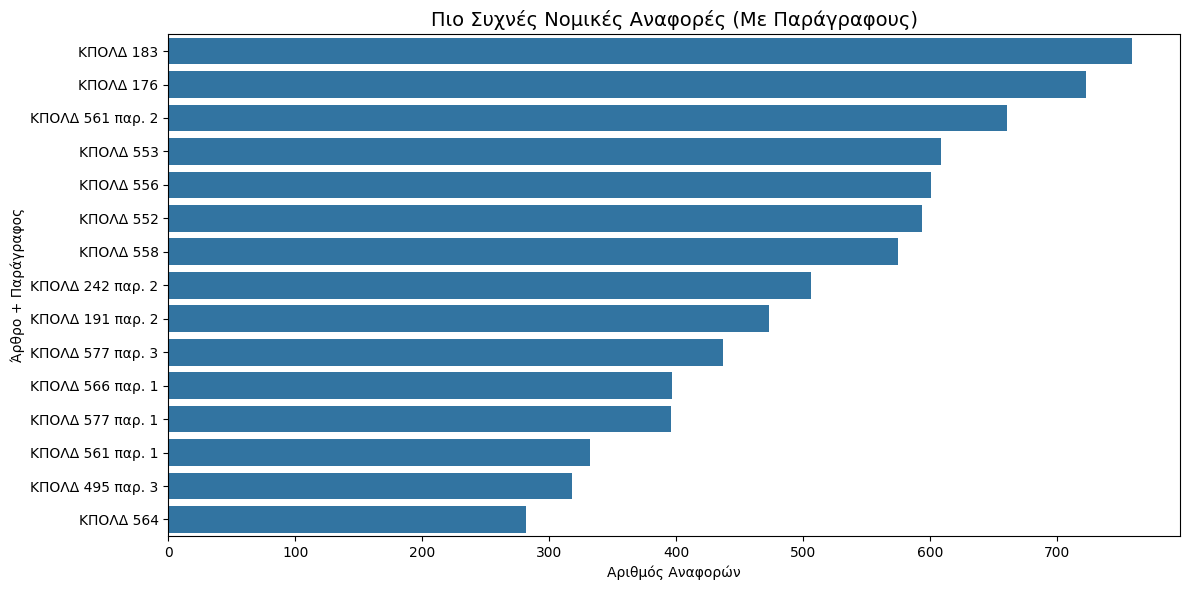

In [79]:
def parse_article_list(val):
    if isinstance(val, str) and val.strip().startswith("["):
        try:
            return ast.literal_eval(val)
        except:
            return []
    elif isinstance(val, list):
        return val
    return []

def clean_article(article):
    if not isinstance(article, str):
        return None
    article = article.strip()
    article = re.sub(r'\s+', ' ', article) 
    return article

scraped_df['articles_parsed_with_paragraphs'] = scraped_df['articles'].apply(parse_article_list)

detailed_articles = [
    clean_article(article)
    for sublist in scraped_df['articles_parsed']
    for article in sublist
    if isinstance(article, str)
]

detailed_articles = [a for a in detailed_articles if a]

detailed_counts = Counter(detailed_articles)
top_detailed = dict(detailed_counts.most_common(15))

if top_detailed:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(top_detailed.values()), y=list(top_detailed.keys()))
    plt.title("Πιο Συχνές Νομικές Αναφορές (Με Παράγραφους)", fontsize=14)
    plt.xlabel("Αριθμός Αναφορών")
    plt.ylabel("Άρθρο + Παράγραφος")
    plt.tight_layout()
    plt.show()
else:
    print("Δεν βρέθηκαν άρθρα με παραγράφους για απεικόνιση.")

Judges with the most cases.

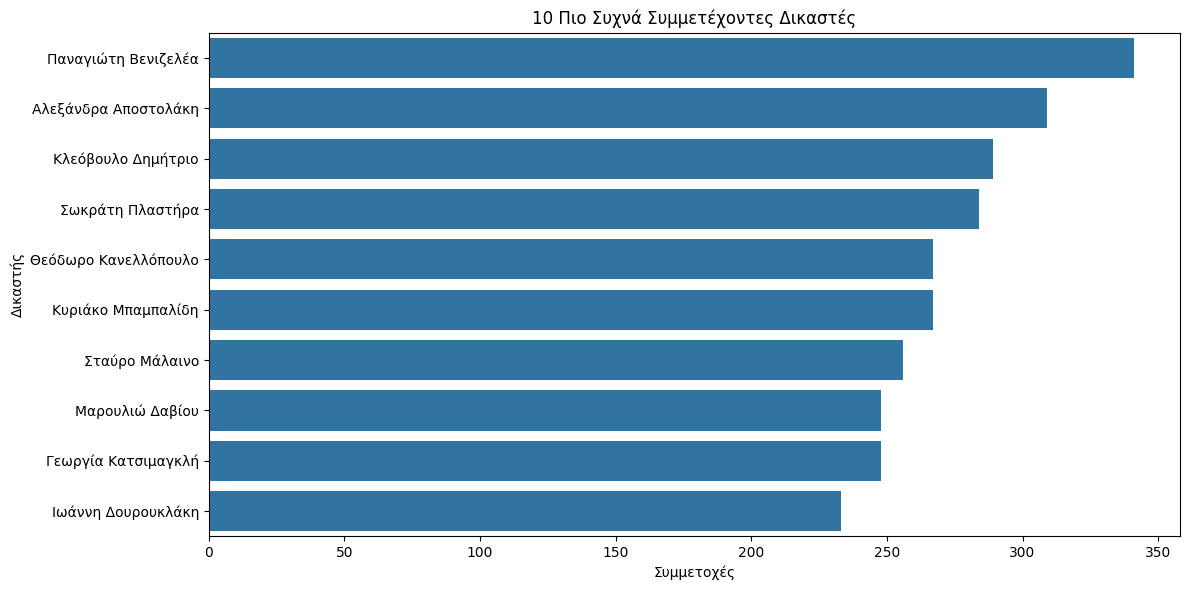

In [80]:
    from collections import Counter
    import ast

    scraped_df['judges_parsed'] = scraped_df['judges'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

    all_judges = [judge.strip() for sublist in scraped_df['judges_parsed'] for judge in sublist if isinstance(judge, str)]
    judge_counts = Counter(all_judges)
    top_judges = dict(judge_counts.most_common(10))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(top_judges.values()), y=list(top_judges.keys()))
    plt.title("10 Πιο Συχνά Συμμετέχοντες Δικαστές")
    plt.xlabel("Συμμετοχές")
    plt.ylabel("Δικαστής")
    plt.tight_layout()
    plt.show()


Bar chart for the destribution of judges number by case.

C:\Users\Admin\AppData\Local\Temp\ipykernel_25256\274696494.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=scraped_df, x='judge_count', palette='Blues_d')


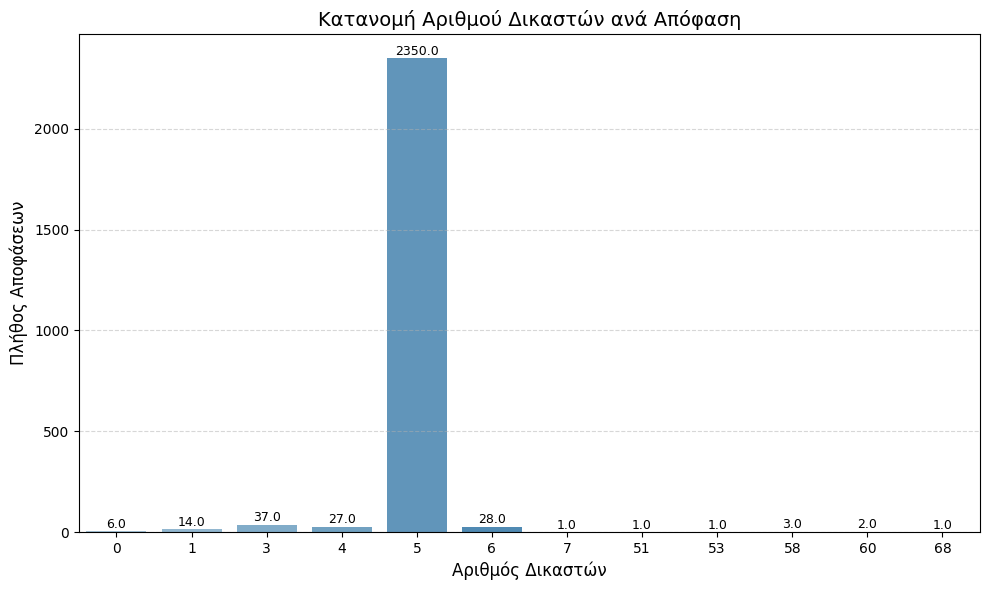

In [45]:
def get_judge_count(judges_value):
    if isinstance(judges_value, list):
        return len(judges_value)
    
    if isinstance(judges_value, str):
        try:
            if judges_value.strip().startswith('['):
                parsed = ast.literal_eval(judges_value)
                if isinstance(parsed, list):
                    return len(parsed)
        except (ValueError, SyntaxError):
            pass
            
        if ',' in judges_value:
            return len(judges_value.split(','))
    
    if isinstance(judges_value, np.ndarray):
        return len(judges_value)
        
   
    return 0
scraped_df['judge_count'] = scraped_df['judges'].apply(get_judge_count)


plt.figure(figsize=(10, 6))
ax = sns.countplot(data=scraped_df, x='judge_count', palette='Blues_d')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("Κατανομή Αριθμού Δικαστών ανά Απόφαση", fontsize=14)
plt.xlabel("Αριθμός Δικαστών", fontsize=12)
plt.ylabel("Πλήθος Αποφάσεων", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



Cases by category.

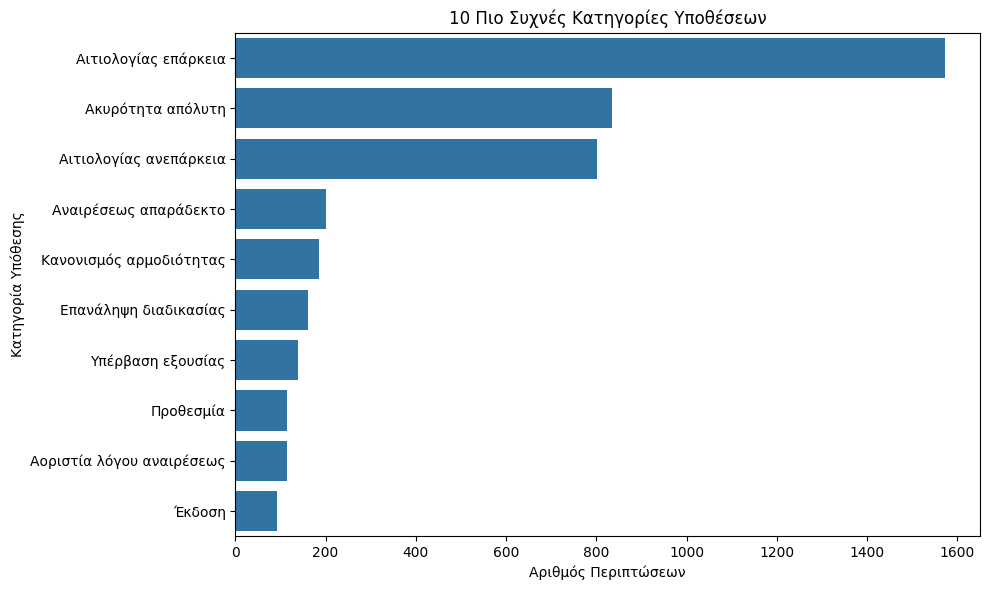

In [81]:
category_counts = huggingface_df['case_category'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.values, y=category_counts.index)
plt.title("10 Πιο Συχνές Κατηγορίες Υποθέσεων")
plt.xlabel("Αριθμός Περιπτώσεων")
plt.ylabel("Κατηγορία Υπόθεσης")
plt.tight_layout()
plt.show()


Most common verbs in final decisions.

C:\Users\Admin\AppData\Local\Temp\ipykernel_25256\949229180.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=verb_counts.values, y=verb_counts.index, palette="deep")


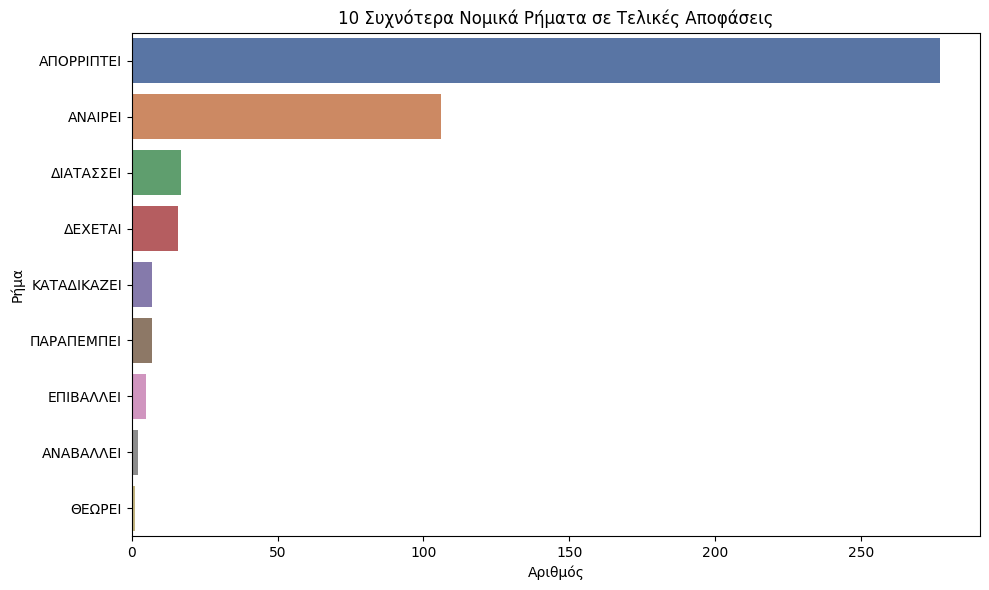

In [82]:
legal_verbs = [
    'ΑΠΟΡΡΙΠΤΕΙ', 'ΔΕΧΕΤΑΙ', 'ΑΝΑΙΡΕΙ', 'ΠΑΡΑΠΕΜΠΕΙ', 'ΚΑΤΑΔΙΚΑΖΕΙ',
    'ΘΕΩΡΕΙ', 'ΕΠΙΒΑΛΛΕΙ', 'ΑΝΑΒΑΛΛΕΙ', 'ΑΝΑΚΑΛΕΙ', 'ΑΝΑΠΕΜΠΕΙ', 'ΔΙΑΤΑΣΣΕΙ'
]

def extract_legal_verb(text):
    if not isinstance(text, str):
        return None
    for word in text.strip().split():
        cleaned = re.sub(r'[^\wΆ-ώΑ-Ωά-ώ]', '', word.upper())
        if cleaned in legal_verbs:
            return cleaned
    return None

verbs = scraped_df['final_decision'].dropna().apply(extract_legal_verb).dropna()
verb_counts = verbs.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=verb_counts.values, y=verb_counts.index, palette="deep")
plt.title("10 Συχνότερα Νομικά Ρήματα σε Τελικές Αποφάσεις")
plt.xlabel("Αριθμός")
plt.ylabel("Ρήμα")
plt.tight_layout()
plt.show()



Most common dates.

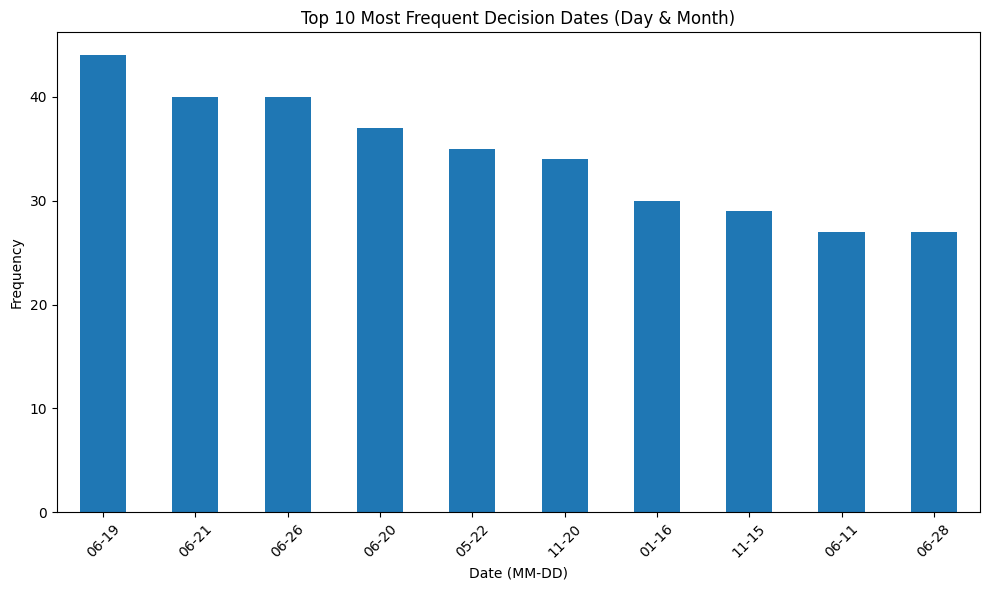

In [83]:
scraped_df["dates"] = pd.to_datetime(scraped_df["dates"], errors='coerce')

valid_dates = scraped_df["dates"].dropna()

month_day = valid_dates.dt.strftime('%m-%d')

date_counts = month_day.value_counts().sort_values(ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
date_counts.head(top_n).plot(kind='bar')
plt.title(f"Top {top_n} Most Frequent Decision Dates (Day & Month)")
plt.xlabel("Date (MM-DD)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


A heat map, for the days with the most cases in 2024.

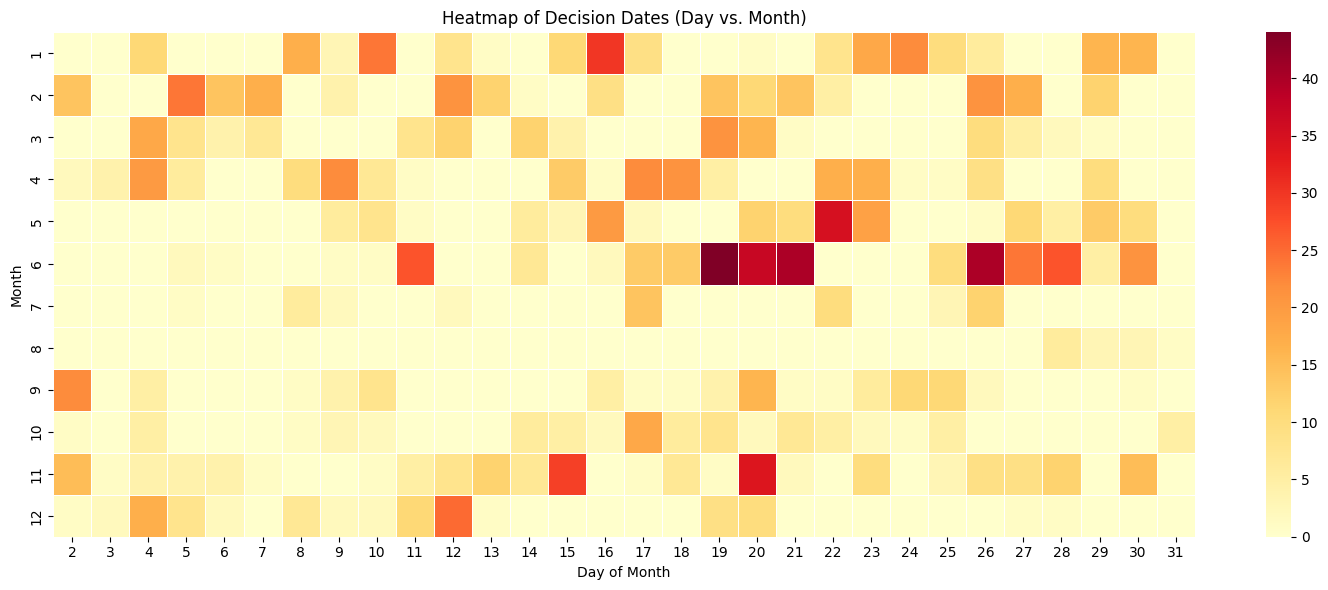

In [84]:
scraped_df["dates"] = pd.to_datetime(scraped_df["dates"], errors='coerce')

valid_dates = scraped_df["dates"].dropna()

date_df = pd.DataFrame({
    "month": valid_dates.dt.month,
    "day": valid_dates.dt.day
})

heatmap_data = date_df.groupby(["month", "day"]).size().unstack(fill_value=0)

plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap of Decision Dates (Day vs. Month)")
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.tight_layout()
plt.show()